In [2]:
!unzip 'Dataset.zip'

Archive:  Dataset.zip
   creating: Dataset/
  inflating: Dataset/Activities.jpeg  
  inflating: Dataset/Barcode.png     
  inflating: Dataset/Bone.jpg        
  inflating: Dataset/Brain.jpg       
  inflating: Dataset/Car.jpg         
  inflating: Dataset/Chest.jpg       
  inflating: Dataset/Cloths.jpg      
  inflating: Dataset/Code.jpg        
  inflating: Dataset/Crack.jpg       
  inflating: Dataset/Cross.jpg       
  inflating: Dataset/Defect.jpg      
  inflating: Dataset/Dust.jpg        
  inflating: Dataset/Emotion.jpg     
  inflating: Dataset/Face.jpg        
  inflating: Dataset/Fire.jpg        
  inflating: Dataset/Gesture.jpg     
  inflating: Dataset/Hand.jpg        
  inflating: Dataset/Iris.jpg        
  inflating: Dataset/Leaf.jpg        
  inflating: Dataset/Lung.png        
  inflating: Dataset/Mask.jpg        
  inflating: Dataset/Melanoma.jpg    
  inflating: Dataset/QR.jpg          
  inflating: Dataset/Retina.jpg      
  inflating: Dataset/Shelf.jpg       
  inf

In [3]:
path = "Dataset"

In [4]:
import os
os.chdir(path)

In [41]:
os.listdir()

['Cross.jpg',
 'Barcode.png',
 'Leaf.jpg',
 'Iris.jpg',
 'Retina.jpg',
 'Emotion.jpg',
 'Chest.jpg',
 'Crack.jpg',
 'QR.jpg',
 'Activities.jpeg',
 'Shelf.jpg',
 'Dust.jpg',
 'hand01.jpg',
 'res.png',
 'Lung.png',
 'Sign.jpg',
 'Tumor.png',
 'Defect.jpg',
 'Car.jpg',
 'Bone.jpg',
 'Mask.jpg',
 'Code.jpg',
 'Hand.jpg',
 'Writing.png',
 'Melanoma.jpg',
 'Brain.jpg',
 'Fire.jpg',
 'Face.jpg',
 'Cloths.jpg',
 'Gesture.jpg']

In [6]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.segmentation import mark_boundaries
from scipy import ndimage as ndi
import pandas as pd
import json
import os
import timeit
import random

In [7]:
def ShowImage(ImageList, nRows = 1, nCols = 2, WidthSpace = 0.00, HeightSpace = 0.00):
    from matplotlib import pyplot as plt
    import matplotlib.gridspec as gridspec

    gs = gridspec.GridSpec(nRows, nCols)
    gs.update(wspace=WidthSpace, hspace=HeightSpace) # set the spacing between axes.
    plt.figure(figsize=(20,20))
    for i in range(len(ImageList)):
        ax1 = plt.subplot(gs[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')

        plt.subplot(nRows, nCols,i+1)

        image = ImageList[i].copy()
        if (len(image.shape) < 3):
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)
        plt.title("Image " + str(i))
        plt.axis('off')

    plt.show()

In [16]:
import os
import pandas as pd

def get_subfiles(dir):
    "Get a list of immediate subfiles"
    return os.listdir(dir)

In [9]:
def ResizeImage(IM, DesiredWidth, DesiredHeight):
    from skimage.transform import rescale, resize

    OrigWidth = float(IM.shape[1])
    OrigHeight = float(IM.shape[0])
    Width = DesiredWidth
    Height = DesiredHeight

    if((Width == 0) & (Height == 0)):
        return IM

    if(Width == 0):
        Width = int((OrigWidth * Height)/OrigHeight)

    if(Height == 0):
        Height = int((OrigHeight * Width)/OrigWidth)

    dim = (Width, Height)
    resizedIM = cv2.resize(IM, dim, interpolation = cv2.INTER_NEAREST)
    return resizedIM

In [10]:
pwd()

'/content/Dataset'

In [46]:
path_Data = '/content/Dataset'
all_names = sorted(get_subfiles(path_Data))
print("Number of Images:", len(all_names))
IMG = []
for i in range(len(all_names)):
  tmp = cv2.imread(os.path.join(path_Data,all_names[i]))
  IMG.append(tmp)

ImageDB = IMG.copy()
NameDB = all_names
print(NameDB)

Number of Images: 30
['.ipynb_checkpoints', 'Activities.jpeg', 'Barcode.png', 'Bone.jpg', 'Brain.jpg', 'Car.jpg', 'Chest.jpg', 'Cloths.jpg', 'Code.jpg', 'Crack.jpg', 'Cross.jpg', 'Defect.jpg', 'Dust.jpg', 'Emotion.jpg', 'Face.jpg', 'Fire.jpg', 'Gesture.jpg', 'Hand.jpg', 'Iris.jpg', 'Leaf.jpg', 'Lung.png', 'Mask.jpg', 'Melanoma.jpg', 'QR.jpg', 'Retina.jpg', 'Shelf.jpg', 'Sign.jpg', 'Tumor.png', 'Writing.png', 'res.png']


Selected Image :  
Index  17 
Name  Hand.jpg


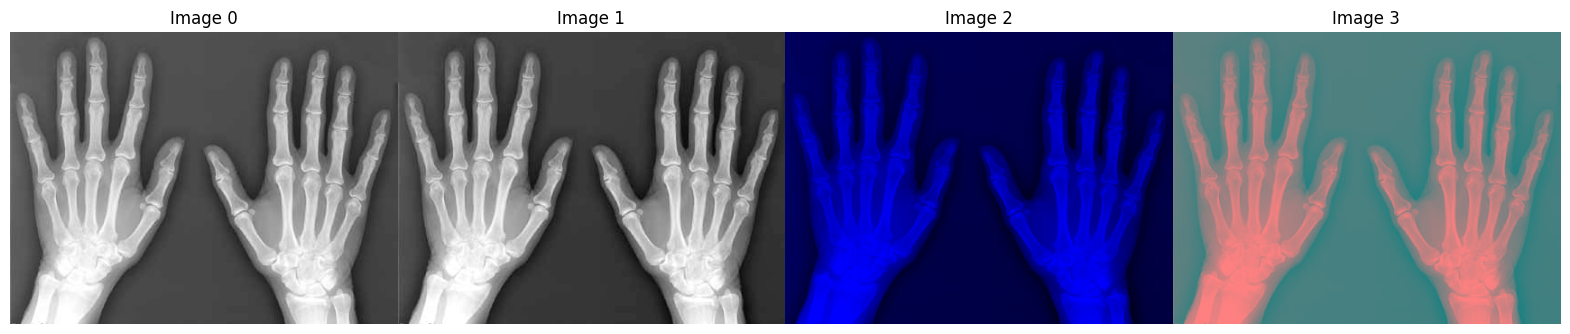

In [70]:
FileName = 'Hand.jpg'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

image_orig = ImageDB[idx]
image_gray = cv2.cvtColor(image_orig,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image_orig, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image_orig, cv2.COLOR_BGR2YCR_CB)
ShowImage([image_orig, image_gray, image_hsv, image_ycbcr], 1, 4)

In [23]:
def p_tile_threshold(image, pct):
  n_pixels = pct * image.shape[0] * image.shape[1]
  hist = np.histogram(image, bins=range(256))[0]
  hist = np.cumsum(hist)

  return np.argmin(np.abs(hist - n_pixels))

#1 Global thresholding and local thresholding

96


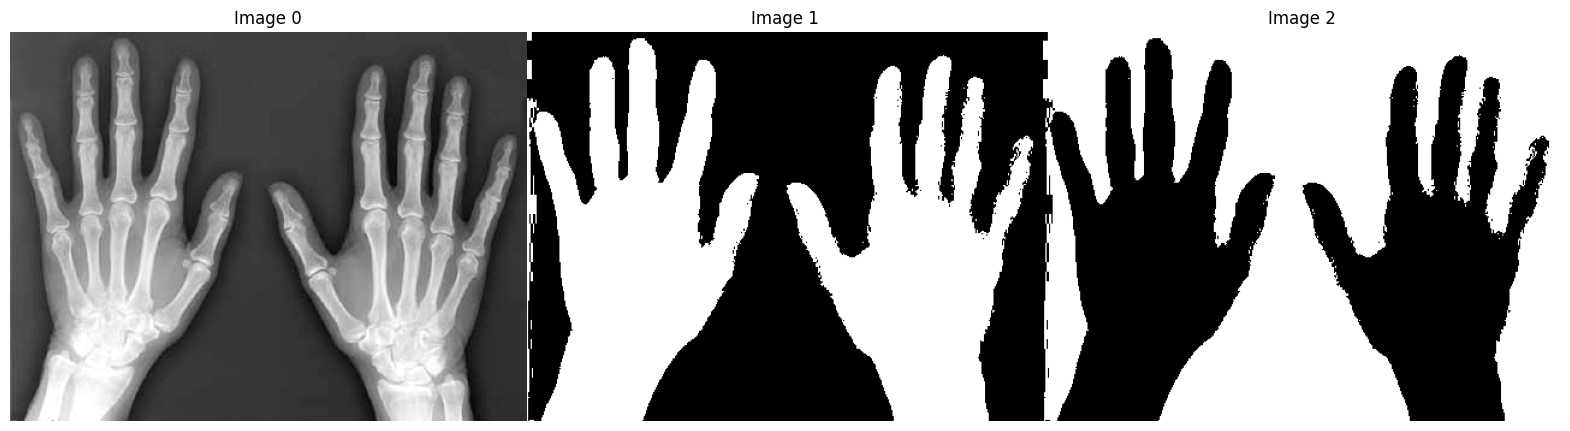

In [71]:
T = p_tile_threshold(image_gray, pct = 0.55)
print(T)

mask_obj = image_gray > T
mask_bg = image_gray <= T
ShowImage([image_gray, mask_obj, mask_bg], 1, 3)

In [72]:
def otsu(gray):
  pixel_number = gray.shape[0] * gray.shape[1]
  mean_weigth = 1.0/pixel_number
  his, bins = np.histogram(gray, np.array(range(0, 256)))
  final_thresh = -1
  final_value = -1

  WBackground = []
  WForeground = []
  Values = []

  for t in bins[1:-1]: # This goes from 1 to 254 uint8 range (Pretty sure wont be those values)
      Wb = np.sum(his[:t]) * mean_weigth
      Wf = np.sum(his[t:]) * mean_weigth

      mub = np.mean(his[:t])
      muf = np.mean(his[t:])

      value = Wb * Wf * (mub - muf) ** 2
      # print("Wb", Wb, "Wf", Wf)
      # print("t", t, "value", value)
      WBackground.append(Wb)
      WForeground.append(Wf)
      Values.append(value)

      if value > final_value:
          final_thresh = t
          final_value = value

  final_img = gray.copy()
  print(final_thresh)
  final_img[gray > final_thresh] = 255
  final_img[gray < final_thresh] = 0
  return final_img, final_thresh, [WBackground, WForeground, Values]

97


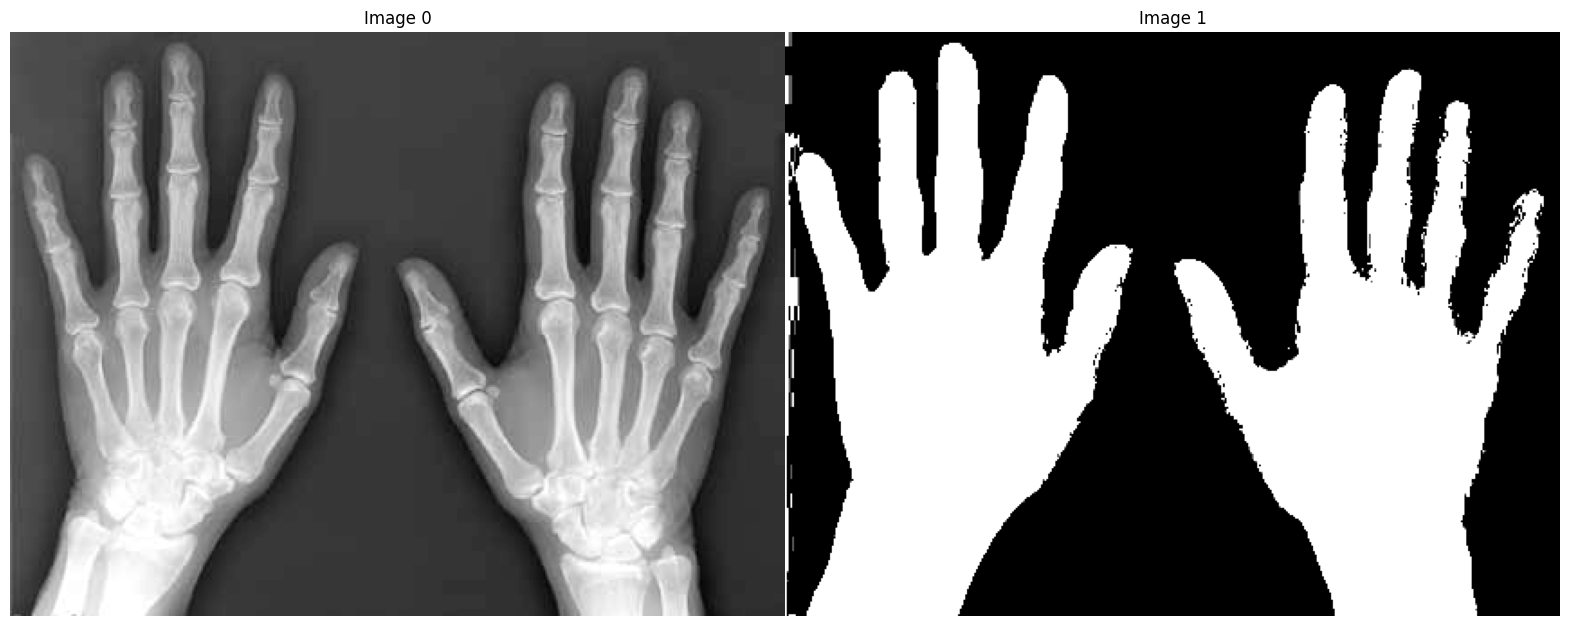

In [73]:
final_img, final_thresh, parms = otsu(image_gray)
ShowImage([image_gray, final_img], 1, 2)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.1777203560149294e-06, 1.4355440712029859e-05, 2.1533161068044788e-05, 2.8710881424059718e-05, 5.024404249210451e-05, 9.331036462819408e-05, 0.00016508756818834337, 0.0002440424921045076, 0.00039477461958082114, 0.0006603502727533735, 0.0008756818834338214, 0.0011699684180304336, 0.0015647430376112546, 0.0019164513350559862, 0.0024834912431811657, 0.003244329600918748, 0.004163077806488659, 0.004995693367786391, 0.006302038472581108, 0.007378696525983348, 0.00867786391042205, 0.010041630778064886, 0.011871949468848694, 0.013781223083548665, 0.016006316393913294, 0.018726672408842952, 0.021583405110536892, 0.024382716049382715, 0.02794286534596612, 0.03147430376112546, 0.0353861613551536, 0.03973585989089865, 0.0441358024691358, 0.04908125179443009, 0.05404823428079242, 0.05978323284524835, 0.06510192362905541, 0.0709158771174275, 0.0760623026126902, 0.0843812805053115, 0.090633074

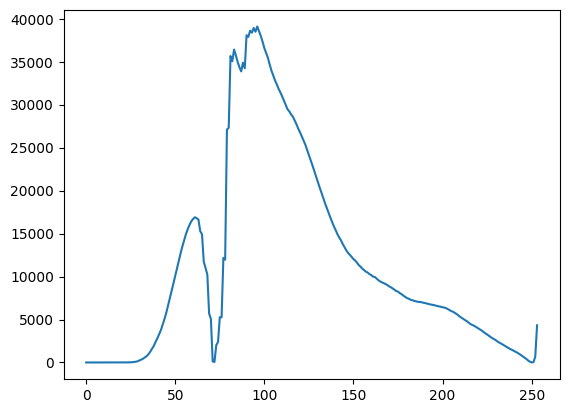

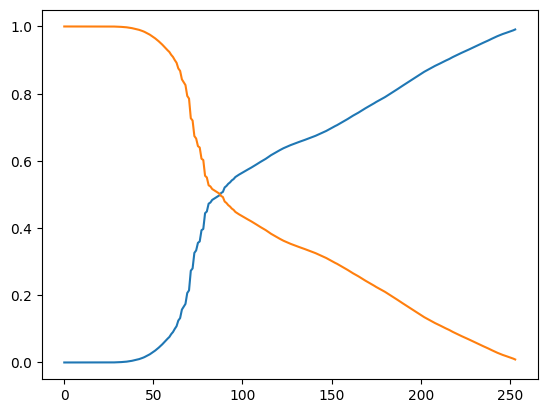

In [74]:
WBackground, WForeground, Values = parms[0], parms[1], parms[2]
print(WBackground)
print(WForeground)
print(Values)

plt.plot(Values)
plt.show()
plt.plot(WBackground)
plt.plot(WForeground)
plt.show()

In [116]:
def two_peaks_threshold(image, smooth_hist=True, sigma=5):
    from scipy.ndimage import gaussian_filter

    hist = np.histogram(image, bins=range(256))[0].astype(float)
    plt.plot(hist)
    plt.show()

    if smooth_hist:
        hist = gaussian_filter(hist, sigma=sigma)
        plt.plot(hist)
        plt.show()

    f_peak = np.argmax(hist)

    # finding second peak
    s_peak = np.argmax((np.arange(len(hist)) - f_peak) ** 2 * hist)

    thr = np.argmin(hist[min(f_peak, s_peak): max(f_peak, s_peak)])
    thr += min(f_peak, s_peak)

    final_img = image.copy()
    print(thr)
    final_img[image > thr] = 255
    final_img[image < thr] = 0

    return final_img, thr, hist

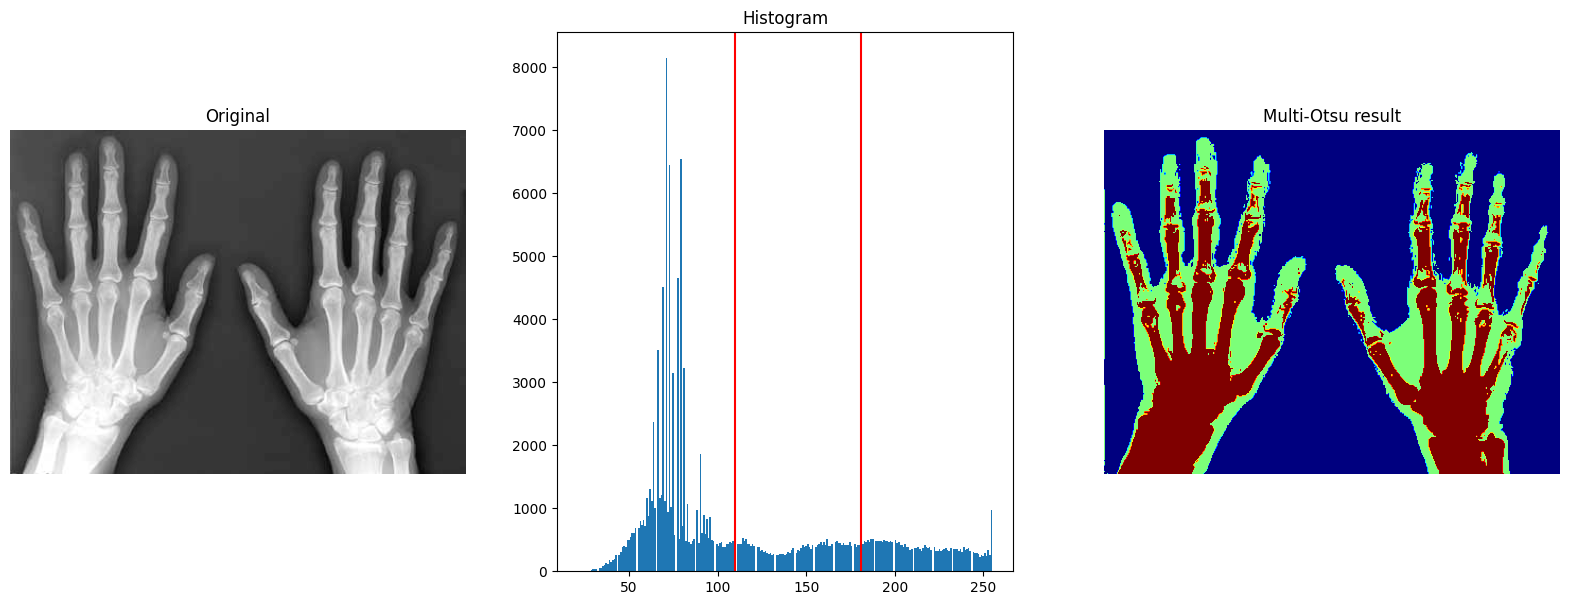

In [75]:
from skimage.filters import threshold_multiotsu
# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image_gray)
# Using the threshold values, we generate the three regions.
regions = np.digitize(image_gray, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
# Plotting the original image.
ax[0].imshow(image_gray, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')
# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image_gray.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')
# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')
plt.subplots_adjust()
plt.show()

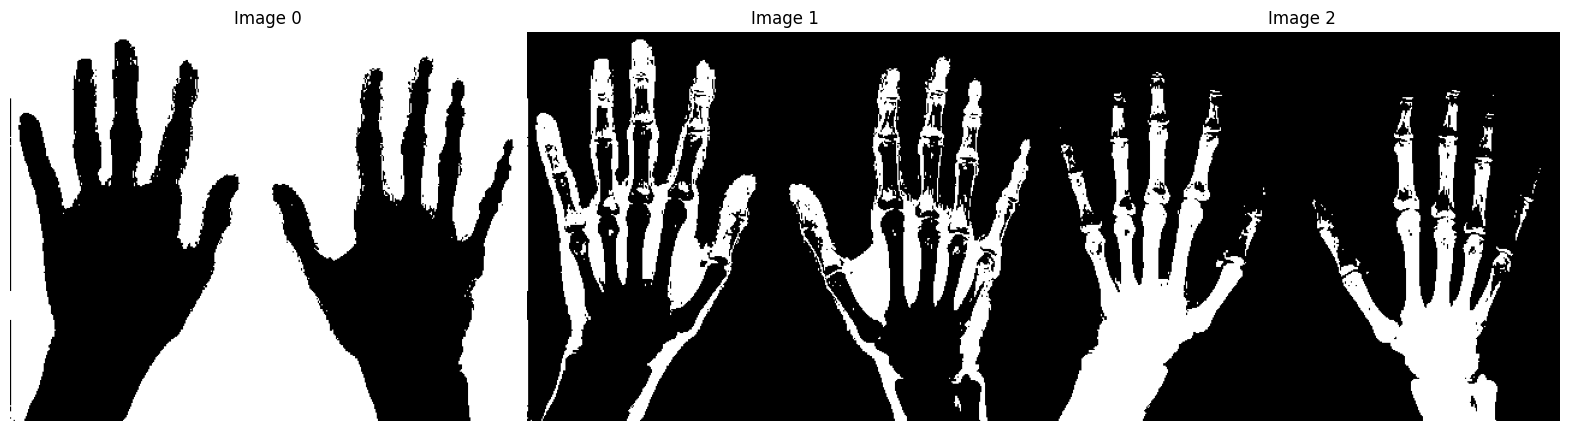

In [76]:
Segments = []
for idx in list(np.unique(regions)):
  mask = regions == idx
  Segments.append(mask)

ShowImage(Segments, 1, len(Segments))

#2

## iris segmentation

Selected Image :  
Index  18 
Name  Iris.jpg


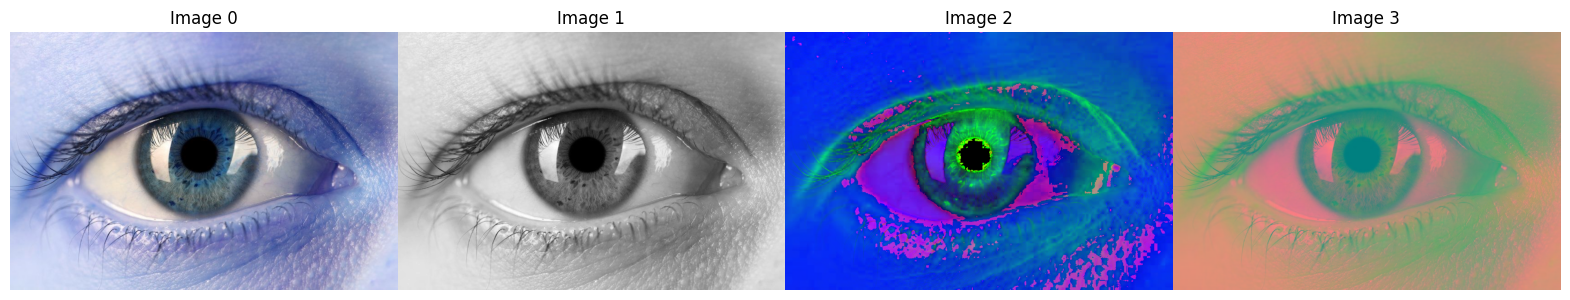

In [97]:
FileName = 'Iris.jpg'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

image_orig = ImageDB[idx]
image_gray = cv2.cvtColor(image_orig,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image_orig, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image_orig, cv2.COLOR_BGR2YCR_CB)
ShowImage([image_orig, image_gray, image_hsv, image_ycbcr], 1, 4)

146


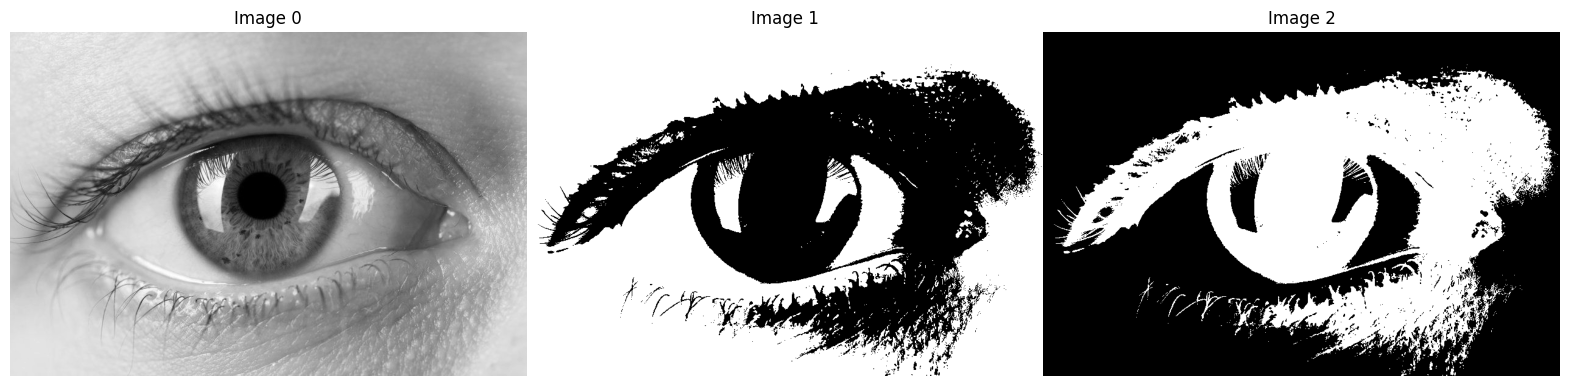

In [98]:
T = p_tile_threshold(image_gray, pct = 0.37)
print(T)

mask_obj = image_gray > T
mask_bg = image_gray <= T
ShowImage([image_gray, mask_obj, mask_bg], 1, 3)

131


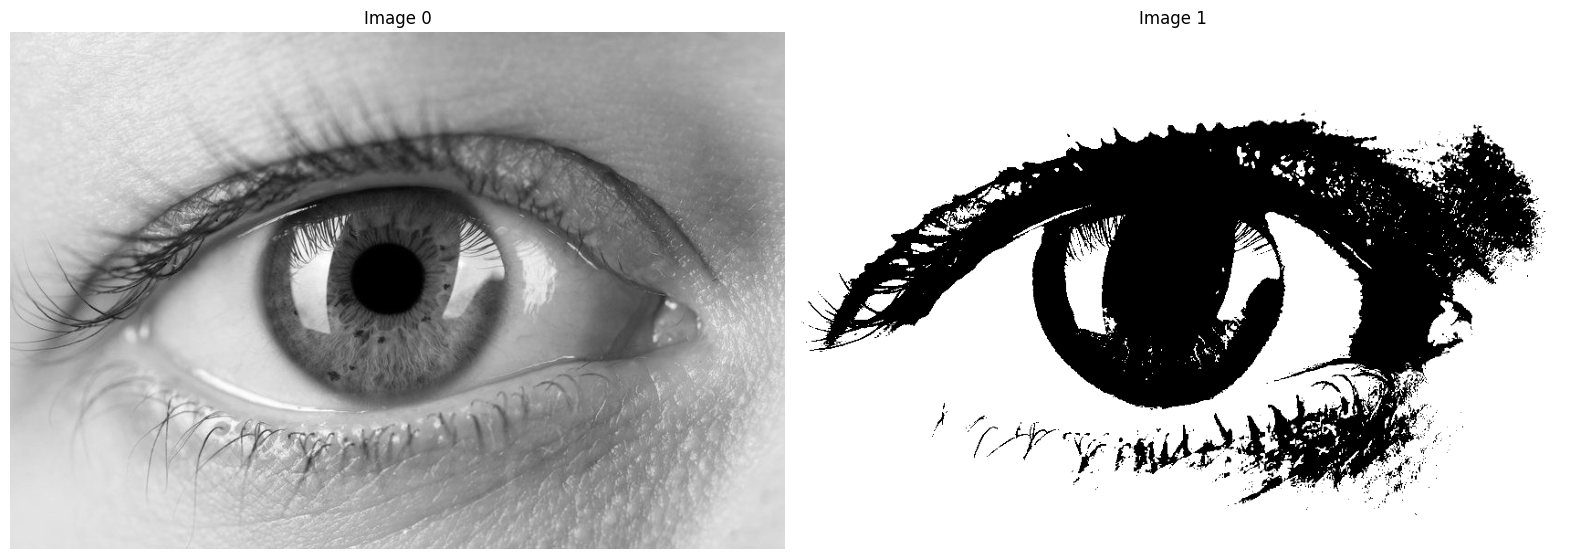

In [99]:
final_img, final_thresh, parms = otsu(image_gray)
ShowImage([image_gray, final_img], 1, 2)

In [88]:
def SelectLargestRegion(Mask):
  import pandas as pd
  from skimage.measure import label, regionprops

  mask = Mask.copy()
  mask_output = mask * 0
  label_img = label(mask)
  regions = regionprops(label_img)
  max_area = 0
  ilabel = 0
  for props in regions:
    area = props.area
    if(area > max_area):
      max_area = area
      ilabel = props.label

  mask_output = mask_output + (label_img == ilabel).astype(int)
  return mask_output

In [90]:
from scipy import ndimage as ndi
def FillHoles(Mask):
  Result = ndi.binary_fill_holes(Mask)
  return Result

In [92]:
def morphology(Mask, Size):
  from skimage.morphology import erosion, dilation, opening, closing, white_tophat
  from skimage.morphology import disk
  selem = disk(abs(Size))
  if(Size > 0):
      result = dilation(Mask, selem)
  else:
      result = erosion(Mask, selem)
  return result

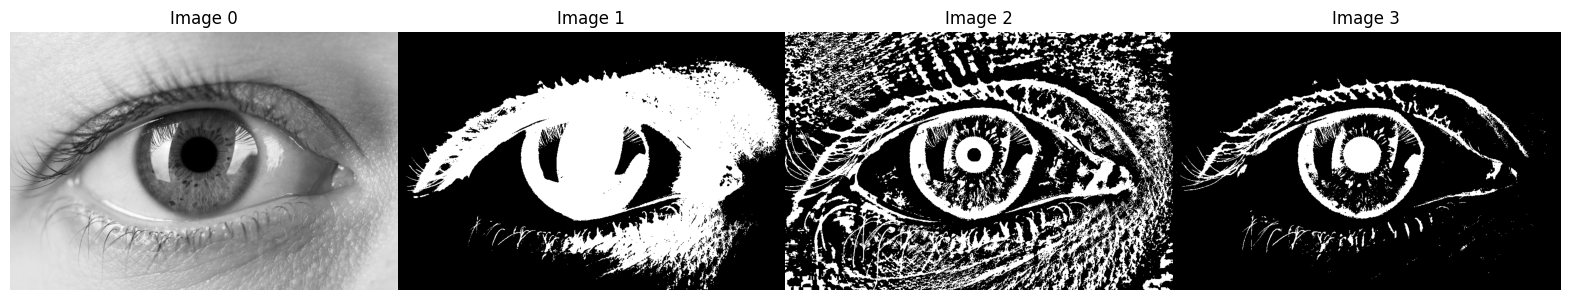

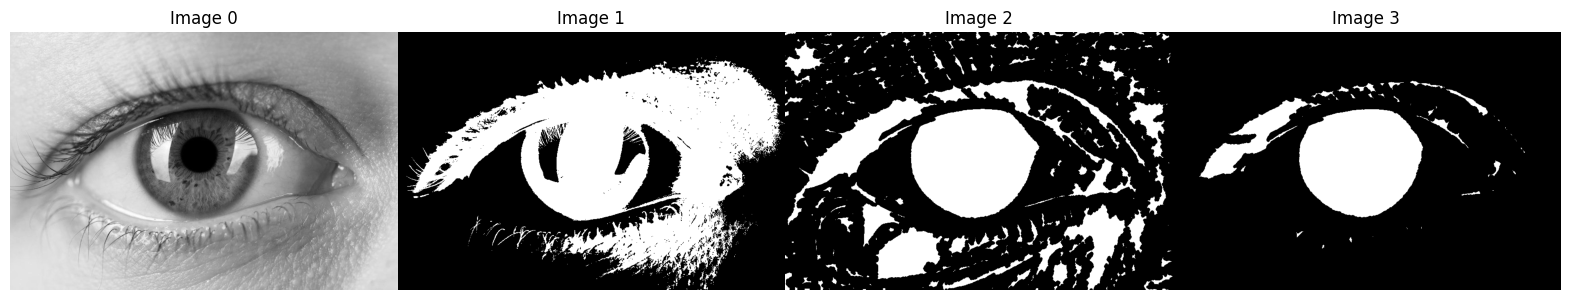

In [100]:
from skimage.filters import (threshold_otsu, threshold_niblack, threshold_sauvola)
image = image_gray
binary_global = image < threshold_otsu(image)

thresh_niblack = threshold_niblack(image, window_size=45)
thresh_sauvola = threshold_sauvola(image, window_size=45)

binary_niblack = image < thresh_niblack
binary_sauvola = image < thresh_sauvola

ShowImage([image, binary_global, binary_niblack, binary_sauvola], 1, 4)

binary_niblack = FillHoles(binary_niblack)
binary_sauvola = FillHoles(binary_sauvola)

binary_niblack = morphology(binary_niblack, -3)
binary_sauvola = morphology(binary_sauvola, -3)

ShowImage([image, binary_global, binary_niblack, binary_sauvola], 1, 4)

In [101]:
def SegmentColorImageByMask(IM, Mask):
    Mask = Mask.astype(np.uint8)
    result = cv2.bitwise_and(IM, IM, mask = Mask)
    return result

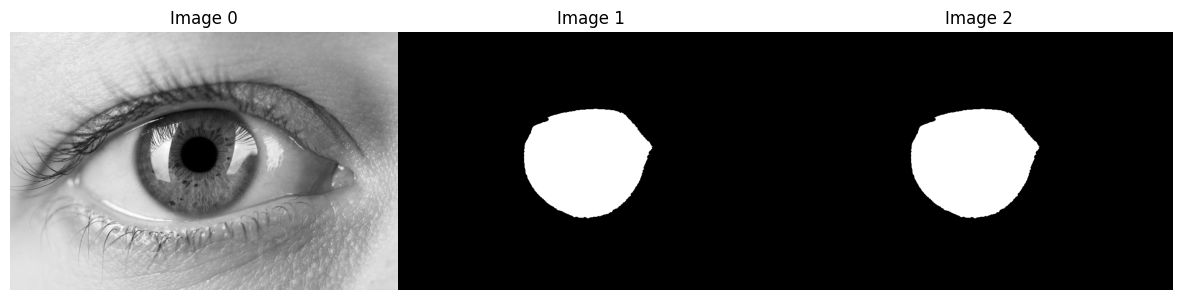

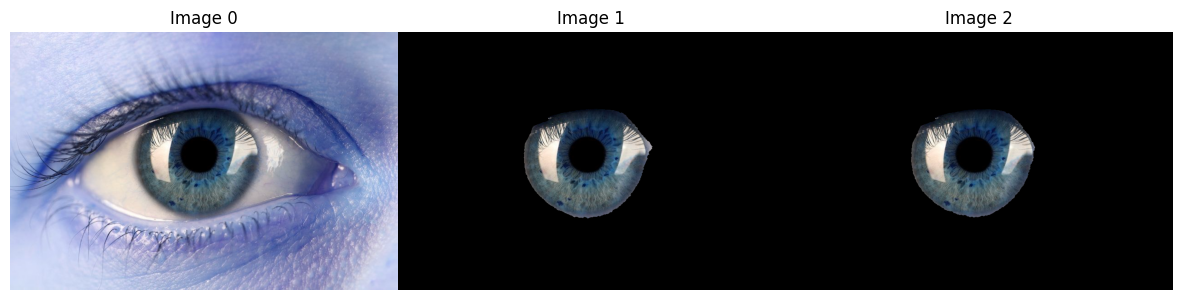

In [106]:
binary_niblack_segmentation = SelectLargestRegion(binary_niblack)
binary_sauvola_segmentation = SelectLargestRegion(binary_sauvola)

ShowImage([image, binary_niblack_segmentation, binary_niblack_segmentation], 1, 4)

binary_niblack_color = SegmentColorImageByMask(image_orig, binary_niblack_segmentation)
binary_sauvola_color = SegmentColorImageByMask(image_orig, binary_sauvola_segmentation)

ShowImage([image_orig, binary_niblack_color, binary_sauvola_color], 1, 4)

## bone segmentation

Selected Image :  
Index  3 
Name  Bone.jpg


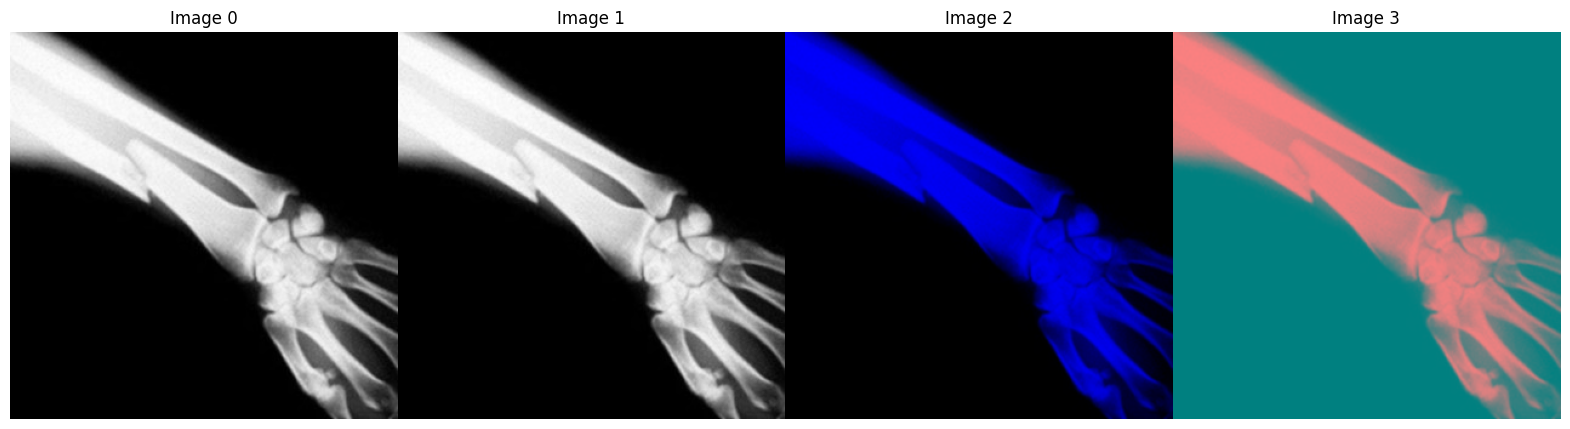

In [108]:
FileName = 'Bone.jpg'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

image_orig = ImageDB[idx]
image_gray = cv2.cvtColor(image_orig,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image_orig, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image_orig, cv2.COLOR_BGR2YCR_CB)
ShowImage([image_orig, image_gray, image_hsv, image_ycbcr], 1, 4)

0


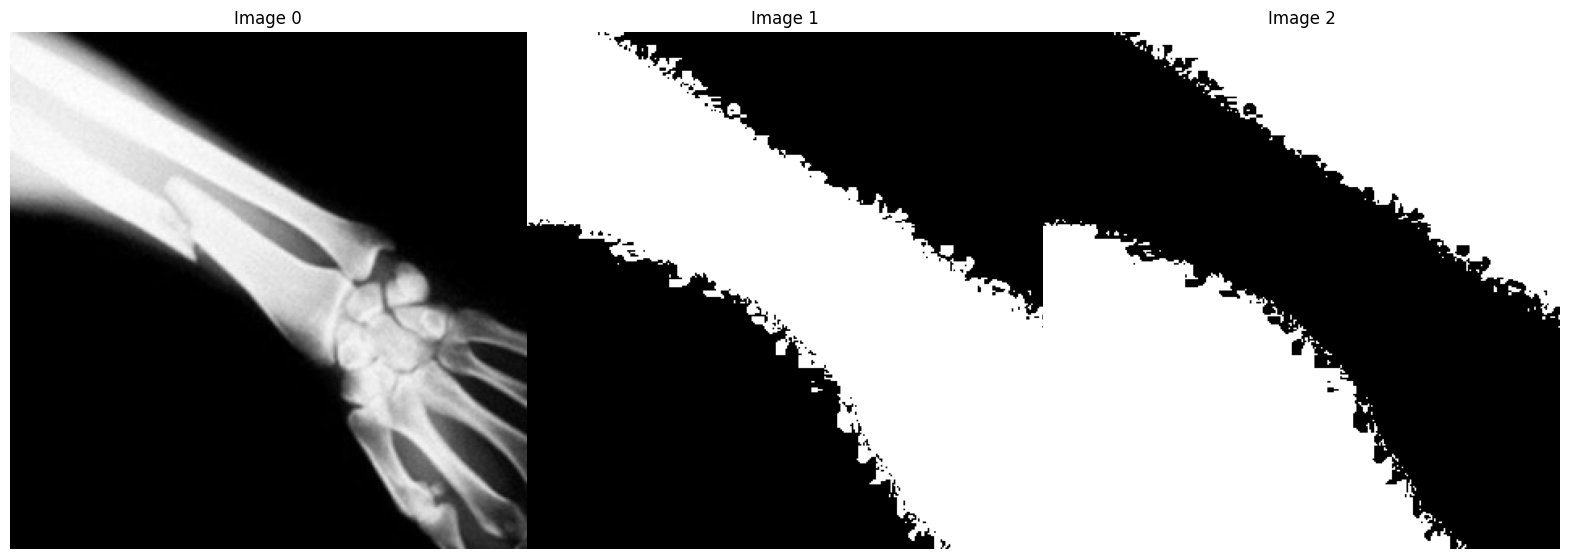

In [109]:
T = p_tile_threshold(image_gray, pct = 0.55)
print(T)

mask_obj = image_gray > T
mask_bg = image_gray <= T
ShowImage([image_gray, mask_obj, mask_bg], 1, 3)

1


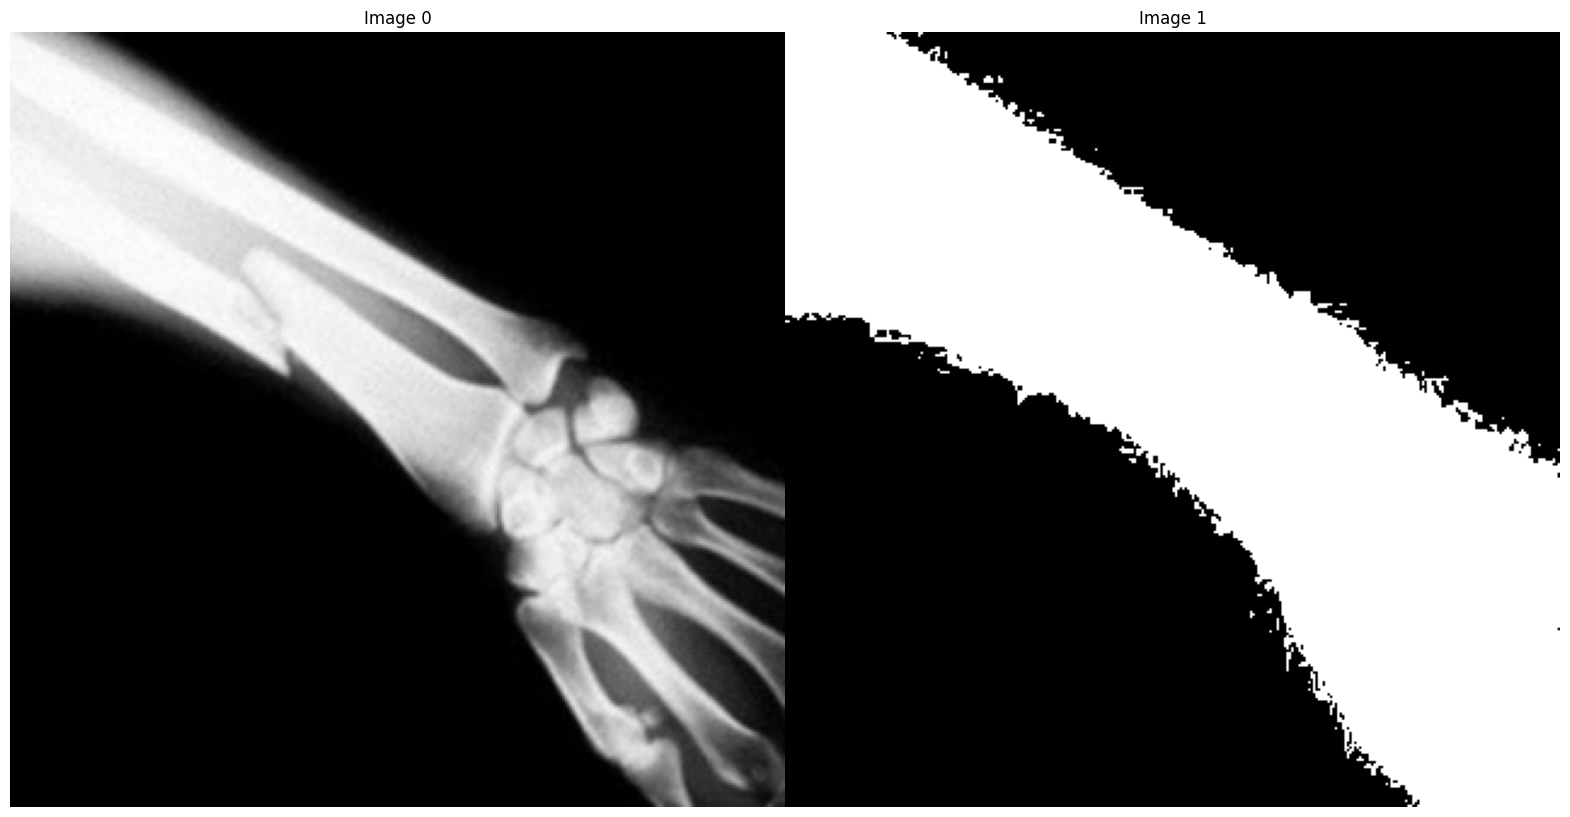

In [110]:
final_img, final_thresh, parms = otsu(image_gray)
ShowImage([image_gray, final_img], 1, 2)

[0.5645703125, 0.58796875, 0.59712890625, 0.601923828125, 0.605458984375, 0.608046875, 0.6104296875, 0.612578125, 0.614931640625, 0.61685546875, 0.618896484375, 0.620888671875, 0.622841796875, 0.625146484375, 0.62751953125, 0.629951171875, 0.6322265625, 0.634267578125, 0.6358984375, 0.637412109375, 0.638857421875, 0.640029296875, 0.641103515625, 0.6422265625, 0.643173828125, 0.64416015625, 0.645048828125, 0.6457421875, 0.646767578125, 0.647568359375, 0.6484375, 0.649248046875, 0.6501953125000001, 0.651142578125, 0.6519921875, 0.652939453125, 0.653701171875, 0.654580078125, 0.655380859375, 0.65626953125, 0.6571582031250001, 0.658037109375, 0.658837890625, 0.659794921875, 0.660537109375, 0.6615625, 0.6626171875, 0.66357421875, 0.664619140625, 0.665693359375, 0.666865234375, 0.6680175781250001, 0.668935546875, 0.669677734375, 0.6705859375000001, 0.67166015625, 0.6724609375, 0.67337890625, 0.67404296875, 0.674873046875, 0.6757128906250001, 0.676484375, 0.677265625, 0.67814453125, 0.6790039

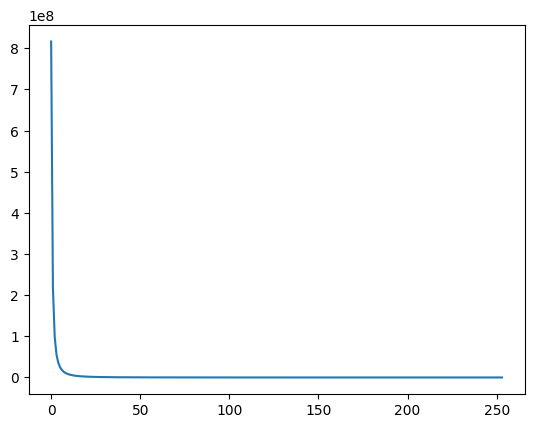

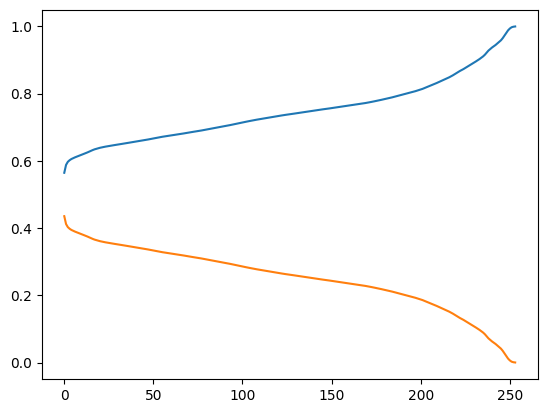

In [111]:
WBackground, WForeground, Values = parms[0], parms[1], parms[2]
print(WBackground)
print(WForeground)
print(Values)

plt.plot(Values)
plt.show()
plt.plot(WBackground)
plt.plot(WForeground)
plt.show()

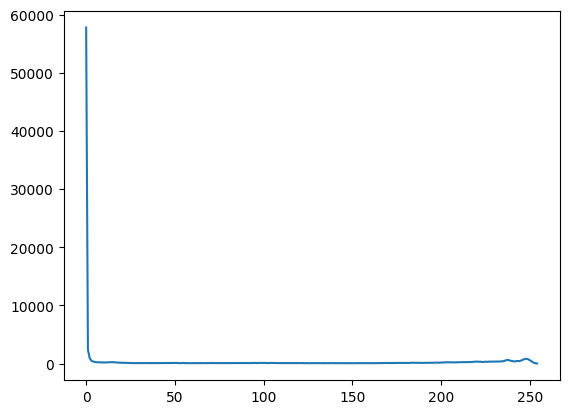

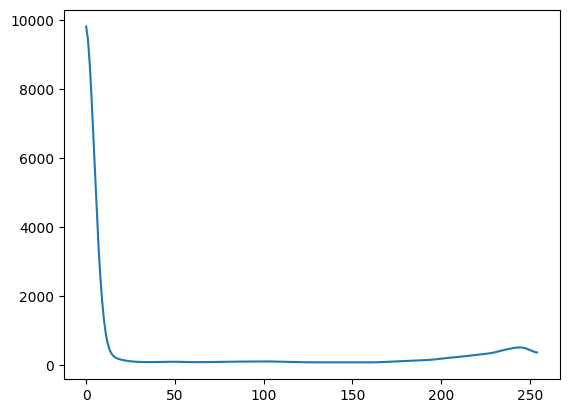

147


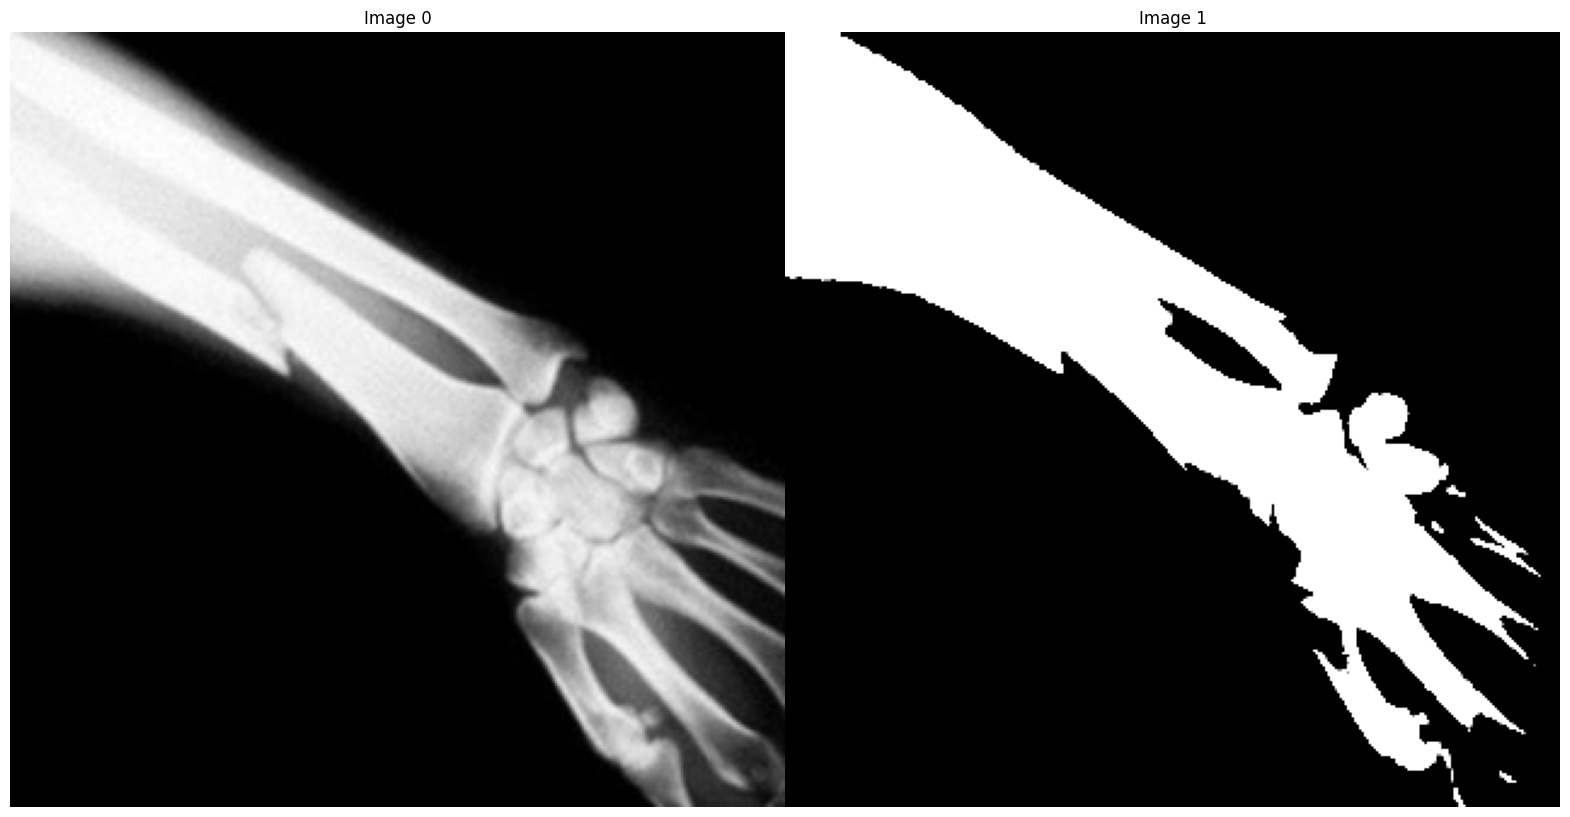

In [117]:
final_img, final_thresh, hist = two_peaks_threshold(image_gray)
ShowImage([image_gray, final_img], 1, 2)

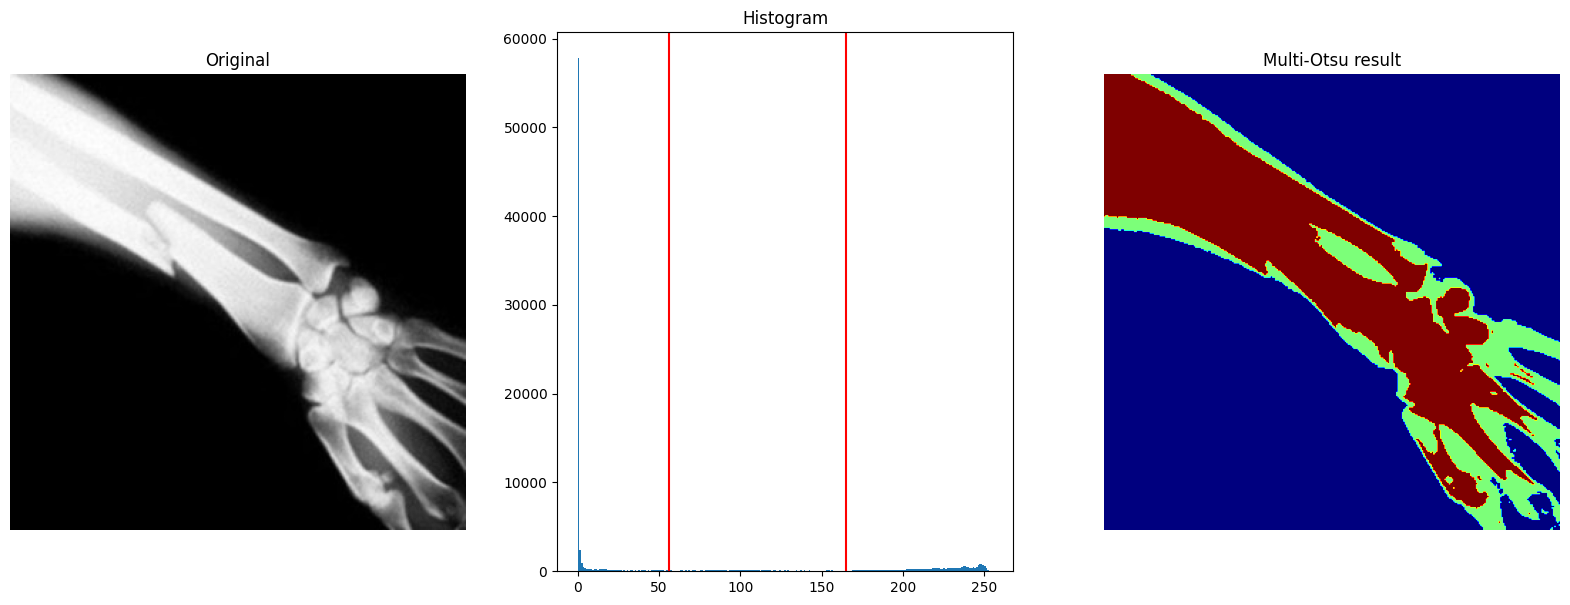

In [118]:
# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image_gray)
# Using the threshold values, we generate the three regions.
regions = np.digitize(image_gray, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
# Plotting the original image.
ax[0].imshow(image_gray, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')
# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image_gray.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')
# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')
plt.subplots_adjust()
plt.show()

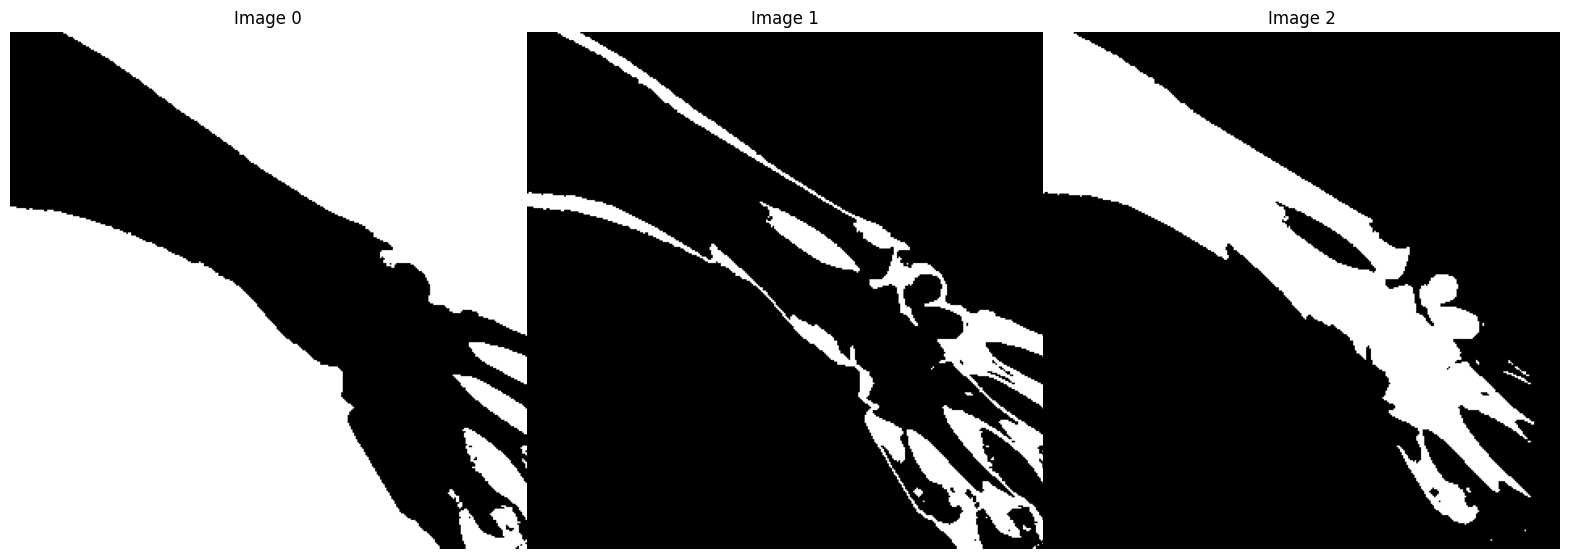

In [119]:
Segments = []
for idx in list(np.unique(regions)):
  mask = regions == idx
  Segments.append(mask)

ShowImage(Segments, 1, len(Segments))

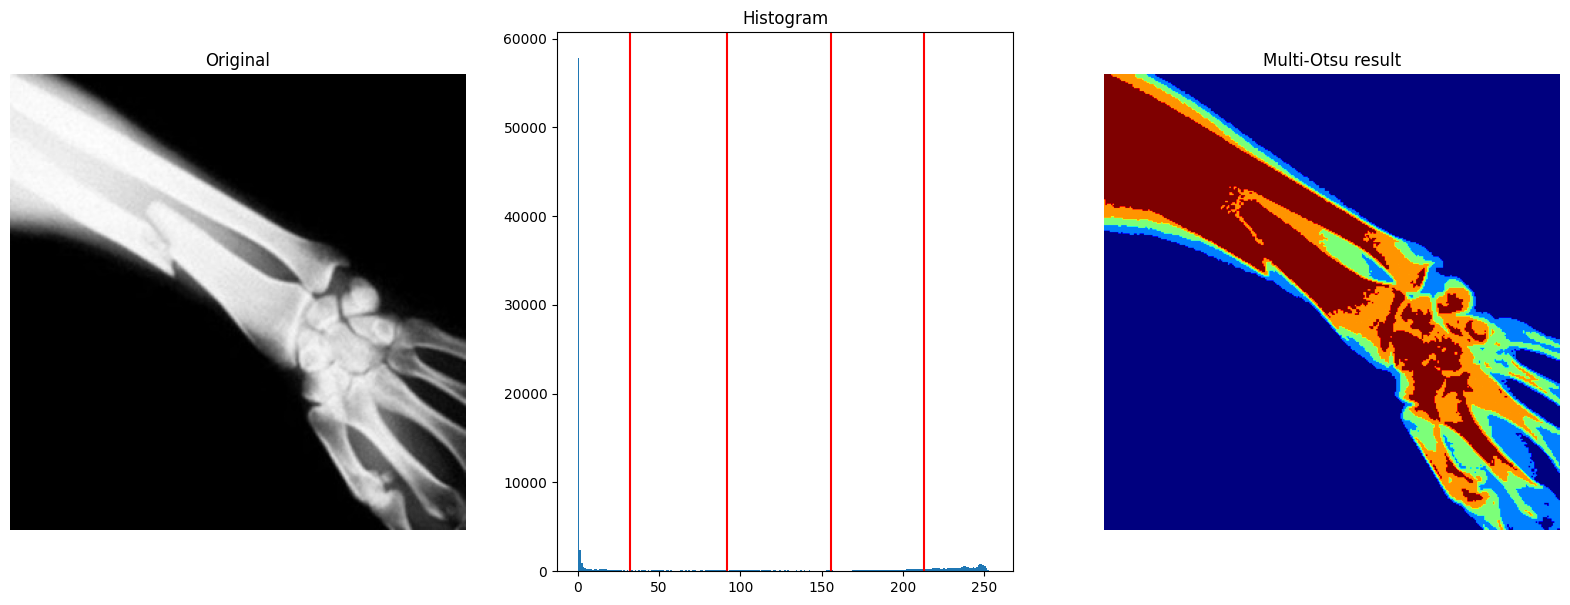

In [120]:
thresholds = threshold_multiotsu(image_gray, classes=5)
regions = np.digitize(image_gray, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
# Plotting the original image.
ax[0].imshow(image_gray, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')
# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image_gray.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')
# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')
plt.subplots_adjust()
plt.show()